# Experiments with CIFAR100 Dataset and Original MoE

The experiments in this notebook include training the original MoE models as follows:

1. original MoE without regularization.
2. original MoE with $L_{importance}$ regularization.
3. original MoE with $L_s$ regularization.
4. train a single model.

In [1]:
import sys
sys.path.append('../src')

In [2]:
from original_moe_training import *

/nobackup/projects/bdrap03/yamuna/miniconda/envs/mnn/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device cuda:0


In [3]:
%matplotlib inline

In [4]:
from collections import OrderedDict

In [5]:
from torch.utils.data import TensorDataset
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms

### NOTE: Pre-trained models are provided to check the results of all the experiments if you do not have the time to train all the models. 

## Load CIFAR10 dataset

In [6]:
# Paths to where the trained models and figures will be stored. You can change this as you see fit.
fig_path = '../figures/cifar100'
model_path = '../models/cifar100'
results_path = '../results/cifar100'

if not os.path.exists(fig_path):
    os.mkdir(fig_path)
if not os.path.exists(model_path):
    os.mkdir(model_path)
if not os.path.exists(results_path):
    os.mkdir(results_path)    

In [7]:
stats = ((0.5074,0.4867,0.4411),(0.2011,0.1987,0.2025))
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32,padding=4,padding_mode="reflect"),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

In [8]:
cifar100_trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
cifar100_testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)
cifar100_testset, cifar100_trainset

Files already downloaded and verified
Files already downloaded and verified


(Dataset CIFAR100
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5074, 0.4867, 0.4411), std=(0.2011, 0.1987, 0.2025))
            ),
 Dataset CIFAR100
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                RandomHorizontalFlip(p=0.5)
                RandomCrop(size=(32, 32), padding=4)
                ToTensor()
                Normalize(mean=(0.5074, 0.4867, 0.4411), std=(0.2011, 0.1987, 0.2025))
            ))

In [9]:
num_classes = 100

In [10]:
trainsize = 50000
testsize = 10000

In [11]:
batch_size = 256

In [12]:
cifar100_trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(cifar100_trainset, range(trainsize)), batch_size=batch_size,
                                          shuffle=True, num_workers=2, pin_memory=True)
cifar100_testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(cifar100_testset, range(testsize)), batch_size=batch_size,
                                         shuffle=True, num_workers=2, pin_memory=True)

In [13]:
import csv
with open('data/cifar100_class_names.txt','r') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=' ')
    classes_cifar100 = []
    for row in csvreader:
        if row:
            classes_cifar100.append(row[1])

classes_cifar100     

['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle',
 'bowl',
 'boy',
 'bridge',
 'bus',
 'butterfly',
 'camel',
 'can',
 'castle',
 'caterpillar',
 'cattle',
 'chair',
 'chimpanzee',
 'clock',
 'cloud',
 'cockroach',
 'couch',
 'crab',
 'crocodile',
 'cup',
 'dinosaur',
 'dolphin',
 'elephant',
 'flatfish',
 'forest',
 'fox',
 'girl',
 'hamster',
 'house',
 'kangaroo',
 'keyboard',
 'lamp',
 'lawn_mower',
 'leopard',
 'lion',
 'lizard',
 'lobster',
 'man',
 'maple_tree',
 'motorcycle',
 'mountain',
 'mouse',
 'mushroom',
 'oak_tree',
 'orange',
 'orchid',
 'otter',
 'palm_tree',
 'pear',
 'pickup_truck',
 'pine_tree',
 'plain',
 'plate',
 'poppy',
 'porcupine',
 'possum',
 'rabbit',
 'raccoon',
 'ray',
 'road',
 'rocket',
 'rose',
 'sea',
 'seal',
 'shark',
 'shrew',
 'skunk',
 'skyscraper',
 'snail',
 'snake',
 'spider',
 'squirrel',
 'streetcar',
 'sunflower',
 'sweet_pepper',
 'table',
 'tank',
 'telephone',
 'television',
 'tig

In [14]:
coarse_labels_cifar100 = OrderedDict()
reverse_coarse_labels_cifar100 = {}
with open('data/cifar100_coarse_labels.txt','r') as fp:
    for line in fp:
        items = line.strip().split('\t')
        coarse_labels_cifar100[items[0]] = items[1]
        for item in items[1].split(','):
            reverse_coarse_labels_cifar100[item.strip()] = items[0]
coarse_labels_cifar100.keys()
reverse_coarse_labels_cifar100

{'beaver': 'aquatic mammals',
 'dolphin': 'aquatic mammals',
 'otter': 'aquatic mammals',
 'seal': 'aquatic mammals',
 'whale': 'aquatic mammals',
 'aquarium_fish': 'fish',
 'flatfish': 'fish',
 'ray': 'fish',
 'shark': 'fish',
 'trout': 'fish',
 'orchid': 'flowers',
 'poppy': 'flowers',
 'rose': 'flowers',
 'sunflower': 'flowers',
 'tulip': 'flowers',
 'bottle': 'food container',
 'bowl': 'food container',
 'can': 'food container',
 'cup': 'food container',
 'plate': 'food container',
 'apple': 'fruit and vegetables',
 'mushroom': 'fruit and vegetables',
 'orange': 'fruit and vegetables',
 'pear': 'fruit and vegetables',
 'sweet_pepper': 'fruit and vegetables',
 'clock': 'household electrical devices',
 'keyboard': 'household electrical devices',
 'lamp': 'household electrical devices',
 'telephone': 'household electrical devices',
 'television': 'household electrical devices',
 'bed': 'household furniture',
 'chair': 'household furniture',
 'couch': 'household furniture',
 'table': '

In [15]:
#Function to display the images
def plot_colour_images(images_to_plot, titles=None, nrows=None, ncols=6, thefigsize=(18,18)):
    # images_to_plot: list of images to be displayed
    # titles: list of titles corresponding to the images
    # ncols: The number of images per row to display. The number of rows 
    #        is computed from the number of images to display and the ncols
    # theFigsize: The size of the layour of all the displayed images
    
    n_images = images_to_plot.shape[0]
    
    # Compute the number of rows
    if nrows is None:
        nrows = np.ceil(n_images/ncols).astype(int)
    
    fig,ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=thefigsize)
    ax = ax.flatten()
    
    for i in range(n_images):
        img = images_to_plot[i,:,:,:]
        npimg = np.clip(img.numpy(),0,1)
        ax[i].imshow(npimg)
        ax[i].axis('off')  
        if titles is not None and i<10:
            ax[i].set_title(titles[i%10])

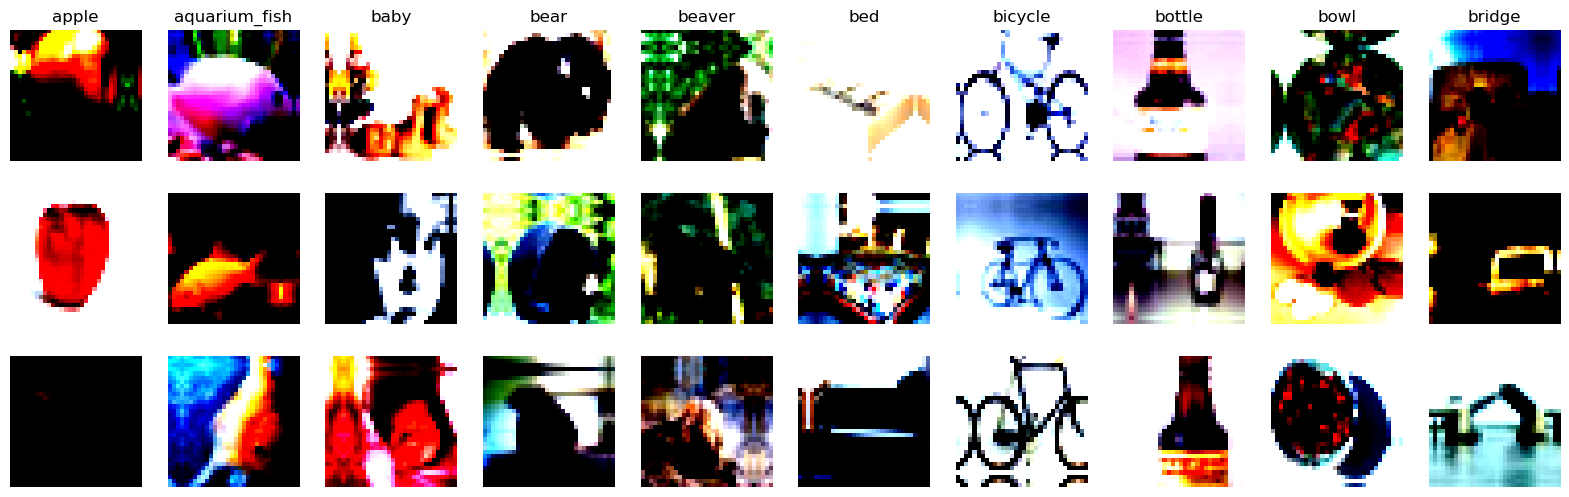

In [16]:
# get some random training images
dataiter = iter(cifar100_trainloader)
images, labels = dataiter.next()

images_to_plot = []
count = 0
selected_labels = []
for i in range(100):
    if count == 10:
        break
    index = np.where(labels==i)[0]
    if len(index) >= 3:
        selected_labels.append(i)
        images_to_plot.append(images[index[0:3],:,:])
        count += 1
    
selected_labels = [classes_cifar100[i] for i in selected_labels]
images_to_plot = torch.transpose(torch.stack(images_to_plot),0,1)
new_shape = images_to_plot.shape
images_to_plot = images_to_plot.reshape(new_shape[0]*new_shape[1], new_shape[2], new_shape[3], new_shape[4])
images_to_plot = images_to_plot.permute(0,2,3,1)
plot_colour_images(images_to_plot, nrows=3, ncols=10,thefigsize=(20,6), titles=selected_labels)

## Define expert and gate networks

In [17]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class expert_layers(nn.Module):
    def __init__(self, num_classes, channels=3):
        super(expert_layers, self).__init__()
        filter_size = 3
        self.filters = 8
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.filters, kernel_size=filter_size, padding=1)
        self.conv2 = nn.Conv2d(in_channels=self.filters, out_channels=self.filters*2, kernel_size=filter_size, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(self.filters*2)
        self.mp = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(in_channels= self.filters*2, out_channels=self.filters*4, kernel_size=filter_size, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=self.filters*4, out_channels=self.filters*4, kernel_size=filter_size, stride=1, padding=1,bias=False)
        self.bn4 = nn.BatchNorm2d(self.filters*4)

        self.conv5 = nn.Conv2d(in_channels= self.filters*4, out_channels=self.filters*8, kernel_size=filter_size, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=self.filters*8, out_channels=self.filters*8, kernel_size=filter_size, stride=1, padding=1,bias=False)
        self.bn8 = nn.BatchNorm2d(self.filters*8)

        self.fc1 = nn.Linear(self.filters*8*2*2,512)
        self.fc2 = nn.Linear(512, 128)
        
        self.out = nn.Linear(in_features=128, out_features=num_classes)
                        
    def forward(self, t):
        # conv 1        
        x = F.relu(self.conv1(t))
        x = self.mp(F.relu(self.conv2(x)))
                
        x = self.mp(F.relu(self.bn4(self.conv3(x))))
        
        x = F.relu(self.conv4(x))
        x = self.mp(F.relu(self.conv5(x)))
        
        x = self.mp(F.relu(self.bn8(self.conv6(x))))       
                    
        x = x.reshape(-1, self.filters*8*2*2)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        x = self.out(x)
        
        # output
        x = F.softmax(x, dim=1)
        
        return x

In [18]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class gate_layers(nn.Module):
    def __init__(self, num_experts):
        super(gate_layers, self).__init__()
        # define layers
        filter_size = 3
        self.filters = 64
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.filters, kernel_size=filter_size, padding=1)
        self.conv2 = nn.Conv2d(in_channels=self.filters, out_channels=self.filters*2, kernel_size=filter_size, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(self.filters*2)
        self.mp = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(in_channels= self.filters*2, out_channels=self.filters*4, kernel_size=filter_size, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=self.filters*4, out_channels=self.filters*4, kernel_size=filter_size, stride=1, padding=1,bias=False)
        self.bn4 = nn.BatchNorm2d(self.filters*4)

        self.conv5 = nn.Conv2d(in_channels= self.filters*4, out_channels=self.filters*8, kernel_size=filter_size, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=self.filters*8, out_channels=self.filters*8, kernel_size=filter_size, stride=1, padding=1,bias=False)
        self.bn8 = nn.BatchNorm2d(self.filters*8)

        self.fc1 = nn.Linear(self.filters*8*2*2,1024)
        self.fc2 = nn.Linear(1024, 128)
        
        self.out = nn.Linear(in_features=128, out_features=num_experts)
                        
    def forward(self,t , T=1.0, y=None):
        # conv 1        
        x = F.relu(self.conv1(t))
        x = self.mp(F.relu(self.conv2(x)))
                
        x = self.mp(F.relu(self.bn4(self.conv3(x))))
        
        x = F.relu(self.conv4(x))
        x = self.mp(F.relu(self.conv5(x)))
        
        x = self.mp(F.relu(self.bn8(self.conv6(x))))       
                    
        x = x.reshape(-1, self.filters*8*2*2)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        x = self.out(x)
        
        # print('G', x.shape)
        
        # output
        x = F.softmax(x/T, dim=1)        
        return x


In [19]:
# create a set of experts
def experts(num_experts, num_classes, expert_layers_type=expert_layers):
    models = []
    for i in range(num_experts):
        models.append(expert_layers_type(num_classes))
    return nn.ModuleList(models)

In [20]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class single_model(nn.Module):
    def __init__(self, num_classes, channels=3):
        super(single_model, self).__init__()
        filter_size = 3
        self.filters = 8
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.filters, kernel_size=filter_size, padding=1)
        self.conv2 = nn.Conv2d(in_channels=self.filters, out_channels=self.filters*2, kernel_size=filter_size, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(self.filters*2)
        self.mp = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(in_channels= self.filters*2, out_channels=self.filters*4, kernel_size=filter_size, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=self.filters*4, out_channels=self.filters*4, kernel_size=filter_size, stride=1, padding=1,bias=False)
        self.bn4 = nn.BatchNorm2d(self.filters*4)

        self.conv5 = nn.Conv2d(in_channels= self.filters*4, out_channels=self.filters*8, kernel_size=filter_size, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=self.filters*8, out_channels=self.filters*8, kernel_size=filter_size, stride=1, padding=1,bias=False)
        self.bn8 = nn.BatchNorm2d(self.filters*8)

        self.fc1 = nn.Linear(self.filters*8*2*2,512)
        self.fc2 = nn.Linear(512, 128)
        
        self.out = nn.Linear(in_features=128, out_features=num_classes)
                        
    def forward(self, t):
        # conv 1        
        x = F.relu(self.conv1(t))
        x = self.mp(F.relu(self.conv2(x)))
                
        x = self.mp(F.relu(self.bn4(self.conv3(x))))
        
        x = F.relu(self.conv4(x))
        x = self.mp(F.relu(self.conv5(x)))
        
        x = self.mp(F.relu(self.bn8(self.conv6(x))))
                            
        x = x.reshape(-1, self.filters*8*2*2)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        x = self.out(x)
        
        # output
        x = F.softmax(x, dim=1)
                
        return x

## Initialize configurations and helper functions

In [21]:
# Compute accuracy of the model
def accuracy(out, yb, mean=True):
    preds = torch.argmax(out, dim=1).to(device, non_blocking=True)
    if mean:
        return (preds == yb).float().mean()
    else:
        return (preds == yb).float()

In [22]:
import sys
sys.path.append('../../WideResNet-pytorch-master')

In [23]:
from wideresnet import WideResNet

In [24]:
number_of_layers = 40
model = WideResNet(depth=number_of_layers, num_classes=100, widen_factor=4)
checkpoint = torch.load('../../WideResNet-pytorch-master/runs/WideResNet-28-10/cifar100.pth.tar')
model.load_state_dict(checkpoint['state_dict'])
model = model.to(device)
model.eval()

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): NetworkBlock(
    (layer): Sequential(
      (0): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (convShortcut): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BasicBlock(
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, 

## Experiments

In [25]:
# Model with gate and expert parameters initialized to default values
model_3 = 'cifar100_wideres_sample_sim'

In [26]:
total_experts = 20

In [27]:
num_epochs = 200

In [28]:
w_sample_sim_same_range = [0.0] #[1e-4]
w_sample_sim_diff_range = [0.0] #[1e-4]
print('w_sample_sim_same_range = ', w_sample_sim_same_range)
print('w_sample_sim_diff_range = ', w_sample_sim_diff_range)

w_sample_sim_same_range =  [0.0]
w_sample_sim_diff_range =  [0.0]


In [29]:
runs = 1

In [30]:
distance_funct = resnet_distance_funct(model).distance_funct
train_original_model(model=model_3, model_name='moe_expectation_model', k=0,
                     trainloader=cifar100_trainloader, testloader=cifar100_testloader, 
                     expert_layers=expert_layers, gate_layers=gate_layers,
                     w_sample_sim_same_range=w_sample_sim_same_range, 
                     w_sample_sim_diff_range=w_sample_sim_diff_range, distance_funct= distance_funct,                    
                     temps=[[1.0]*num_epochs],runs=runs, num_classes=num_classes, total_experts=total_experts, 
                     num_epochs=num_epochs, model_path=model_path)

w_importance 0.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
Run: 1
p*y tensor([[0.0096, 0.0100, 0.0099,  ..., 0.0102, 0.0098, 0.0096],
        [0.0096, 0.0100, 0.0097,  ..., 0.0102, 0.0098, 0.0096],
        [0.0096, 0.0098, 0.0097,  ..., 0.0103, 0.0101, 0.0097],
        ...,
        [0.0096, 0.0101, 0.0098,  ..., 0.0101, 0.0097, 0.0094],
        [0.0098, 0.0100, 0.0099,  ..., 0.0102, 0.0098, 0.0095],
        [0.0096, 0.0102, 0.0098,  ..., 0.0102, 0.0097, 0.0095]],
       device='cuda:0', grad_fn=<SumBackward1>)
output tensor([[0.0100, 0.0100, 0.0100,  ..., 0.0100, 0.0100, 0.0100],
        [0.0100, 0.0100, 0.0100,  ..., 0.0100, 0.0100, 0.0100],
        [0.0100, 0.0100, 0.0100,  ..., 0.0100, 0.0100, 0.0100],
        ...,
        [0.0100, 0.0100, 0.0100,  ..., 0.0100, 0.0100, 0.0100],
        [0.0100, 0.0100, 0.0100,  ..., 0.0100, 0.0100, 0.0100],
        [0.0100, 0.0100, 0.0100,  ..., 0.0100, 0.0100, 0.0100]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)
p*y tensor([[0.0096, 0.01


KeyboardInterrupt



### Experiment 1: Original MoE model trained without gate regularization

In [95]:
# Model with gate and expert parameters initialized to default values
model_1 = 'cifar100_without_reg'

In [96]:
total_experts = 20

In [97]:
num_epochs = 80

In [98]:
runs = 1

In [99]:
temps = [[1.0]*num_epochs]

In [100]:
train_original_model(model_1, cifar100_trainloader, cifar100_testloader, runs, temps=temps,
                     num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

w_importance 0.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
Run: 1
epoch 0 training loss 4.05 , training accuracy 0.09 , test accuracy 0.10
epoch 1 training loss 3.68 , training accuracy 0.14 , test accuracy 0.15
epoch 2 training loss 3.45 , training accuracy 0.18 , test accuracy 0.19
epoch 3 training loss 3.25 , training accuracy 0.22 , test accuracy 0.22
epoch 4 training loss 3.06 , training accuracy 0.25 , test accuracy 0.25
epoch 5 training loss 2.87 , training accuracy 0.29 , test accuracy 0.29
epoch 6 training loss 2.72 , training accuracy 0.33 , test accuracy 0.31
epoch 7 training loss 2.58 , training accuracy 0.36 , test accuracy 0.33
epoch 8 training loss 2.45 , training accuracy 0.38 , test accuracy 0.38
epoch 9 training loss 2.35 , training accuracy 0.41 , test accuracy 0.39
epoch 10 training loss 2.26 , training accuracy 0.43 , test accuracy 0.40
epoch 11 training loss 2.18 , training accuracy 0.44 , test accuracy 0.42
epoch 12 training loss 2.10 , training accuracy 0.46 ,

### Experiment 2: Original MoE model trained with $L_{importance}$ regularization

In [ ]:
# Model with gate and expert parameters initialized to default values
model_2 = 'cifar_with_reg'

In [ ]:
total_experts = 20

In [ ]:
num_epochs = 20

In [ ]:
w_importance_range = [i * 0.2 for i in range(1, 6)]
w_importance_range = [0.6]
print('w_importance_range = ', ['{:.1f}'.format(w) for w in w_importance_range])

In [ ]:
temps = [[1]*num_epochs]

In [ ]:
runs = 1

In [ ]:
train_original_model(model_2, cifar100_trainloader, cifar100_testloader, runs, temps=temps,
                     w_importance_range=w_importance_range, num_classes=num_classes, 
                     total_experts=total_experts, num_epochs=num_epochs)

### Experiment 3: Original MoE model trained with sample similarity regularization, $L_s$

In [ ]:
model_3 = 'cifar_with_reg'

In [ ]:
total_experts = 20

In [ ]:
num_epochs = 40

In [ ]:
temps = [[1]*num_epochs]

In [ ]:
w_sample_sim_same_range = [1e-4]
w_sample_sim_diff_range = [1e-7]
print('w_sample_sim_same_range = ', w_sample_sim_same_range)
print('w_sample_sim_diff_range = ', w_sample_sim_diff_range)

In [ ]:
runs = 1

In [ ]:
train_original_model(model_3, cifar100_trainloader, cifar100_testloader, runs, temps=temps,
                                     w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range, 
                                     num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

### Experiment 4: Training the single model

In [91]:
model_4 = 'cifar100_single_model'

In [92]:
num_epochs = 80

In [93]:
runs = 1

In [94]:
train_single_model(model_4, cifar100_trainloader, cifar100_testloader, num_classes, num_epochs, runs)

Run 1
epoch 0 training loss 4.01 , training accuracy 0.08 , test accuracy 0.12
epoch 1 training loss 3.43 , training accuracy 0.17 , test accuracy 0.20
epoch 2 training loss 3.01 , training accuracy 0.25 , test accuracy 0.26
epoch 3 training loss 2.69 , training accuracy 0.32 , test accuracy 0.35
epoch 4 training loss 2.45 , training accuracy 0.37 , test accuracy 0.38
epoch 5 training loss 2.28 , training accuracy 0.41 , test accuracy 0.42
epoch 6 training loss 2.12 , training accuracy 0.46 , test accuracy 0.45
epoch 7 training loss 2.00 , training accuracy 0.49 , test accuracy 0.46
epoch 8 training loss 1.91 , training accuracy 0.50 , test accuracy 0.47
epoch 9 training loss 1.84 , training accuracy 0.53 , test accuracy 0.48
epoch 10 training loss 1.76 , training accuracy 0.55 , test accuracy 0.52
epoch 11 training loss 1.71 , training accuracy 0.56 , test accuracy 0.53
epoch 12 training loss 1.65 , training accuracy 0.58 , test accuracy 0.53
epoch 13 training loss 1.61 , training acc

## Results

### Collect the train error, test error for the trained single models and store in the '../results/cifar_results.csv' file.

In [41]:
pre_trained_model_path = '../models/hidden_128'

In [42]:
import sys
sys.path.append('../src')

In [30]:
# Compute accuracy of the model
def accuracy_top5(out, yb):
    preds = torch.argsort(out, dim=1,descending=True).to(device, non_blocking=True)
    N = preds.shape[0]
    correct = 0
    for i in range(N):
        # print(yb[i], preds[i,0:5], out[i, preds[i,0:5]])
        # print(out[i, preds[i,:]])
        if yb[i] in preds[i,0:5]:
            correct += 1
    return correct/N
    

In [31]:
import csv

m = 'cifar100_single_model'
plot_file = generate_plot_file(m, specific=str(num_classes)+'_models.pt')
models = torch.load(open(os.path.join(pre_trained_model_path, plot_file),'rb'), map_location=device)
filename = os.path.join(results_path, 'cifar100_results_hidden_128.csv')
if os.path.exists(filename):
    p = 'a'
else:
    p = 'w'
        
header = ['filename', 'train error', 'top-1 error', 'top-5 error', 'mutual information', 'sample entropy', 'experts usage']
    
with open(filename, p) as f:
    writer = csv.writer(f)        

    if p == 'w':            
        writer.writerow(header)
    for i, model in enumerate(models['models']):
        data = ['']*5
        data[0] = m+'_'+str(i)
        running_top1_accuracy = 0.0
        running_top5_accuracy = 0.0
        num_batches = 0
        train_error = 1-models['history'][i]['accuracy'][-1]
        data[1] = train_error
        for test_inputs, test_labels in cifar100_testloader:
            test_inputs, test_labels = test_inputs.to(device, non_blocking=True), test_labels.to(device, non_blocking=True)                
            outputs = model(test_inputs)
            running_top1_accuracy += accuracy(outputs, test_labels)
            running_top5_accuracy += accuracy_top5(outputs, test_labels)
            num_batches += 1
        top1_error = 1-(running_top1_accuracy/num_batches)
        top5_error = 1-(running_top5_accuracy/num_batches)
        data[2] = top1_error.item()
        data[3] = top5_error
        
        writer.writerow(data)


torch.Size([10000])


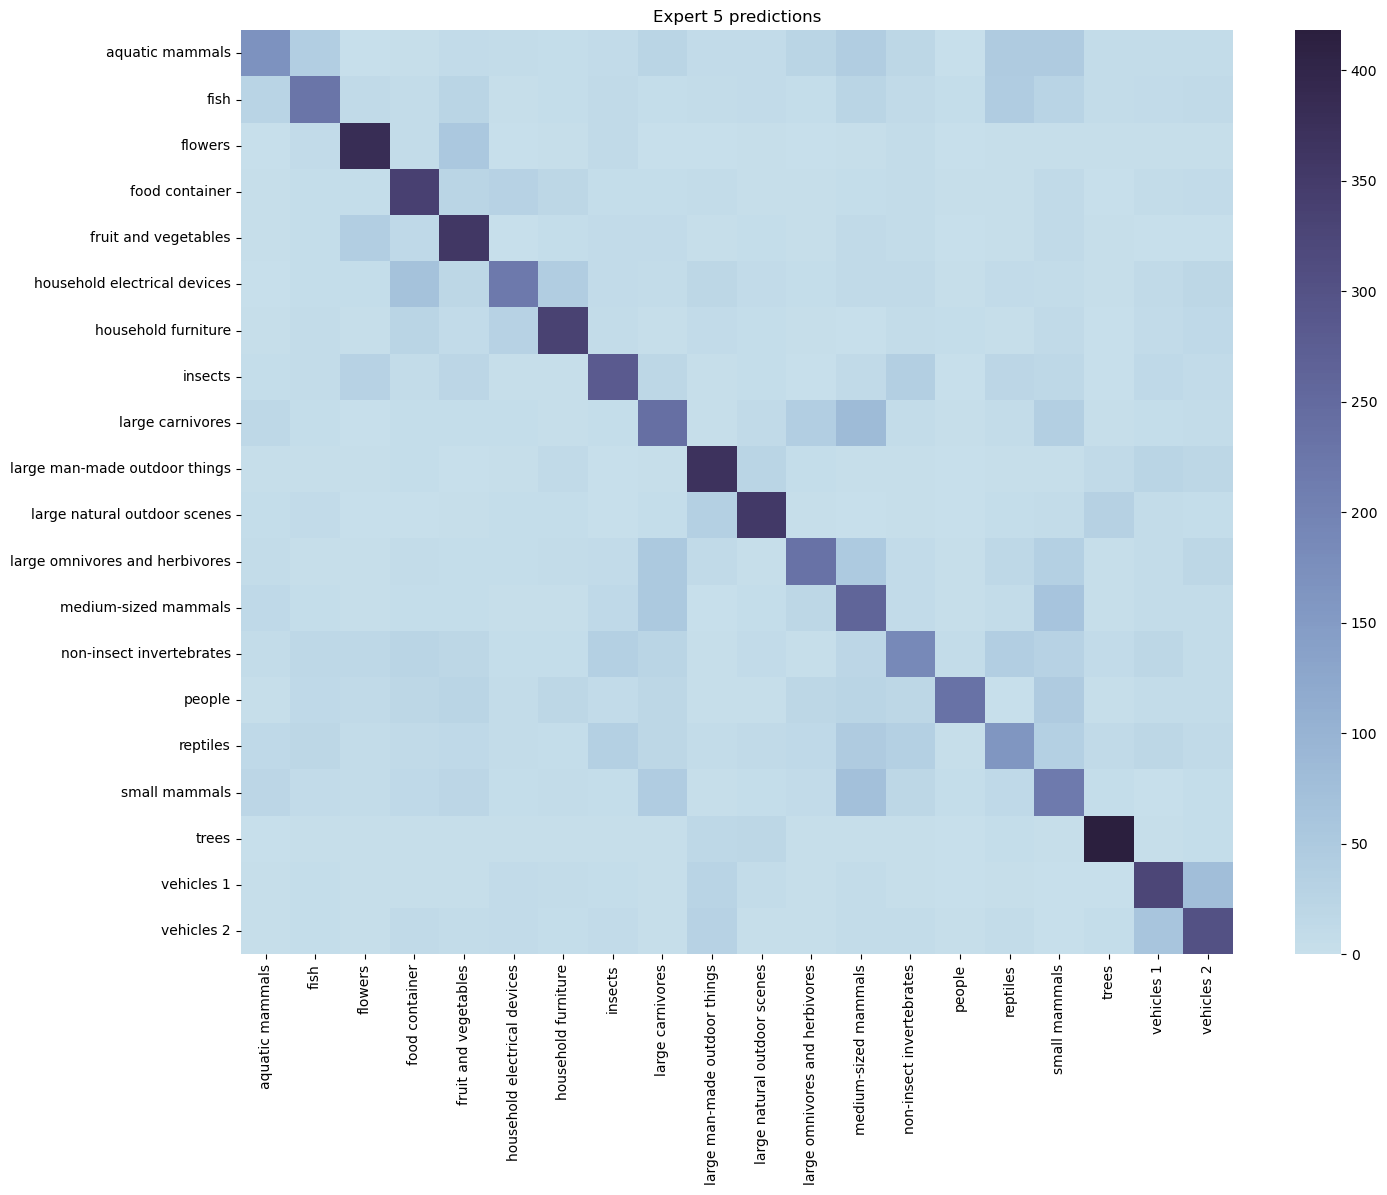

In [76]:
m = 'cifar100_single_model'

plot_file = generate_plot_file(m, specific=str(num_classes)+'_models.pt')
models = torch.load(open(os.path.join(pre_trained_model_path, plot_file),'rb'), map_location=device)
min_train_error = float('inf')
best_model = models['models'][0]
for i, model in enumerate(models['models']):
    train_error = 1-models['history'][i]['accuracy'][-1]
    if train_error < min_train_error:
        min_train_error = train_error
        best_model = model
true_labels = []
pred_labels = []
for test_inputs, test_labels in cifar100_testloader:
    test_inputs, test_labels = test_inputs.to(device, non_blocking=True), test_labels.to(device, non_blocking=True)                
    outputs = model(test_inputs)
    true_labels += test_labels
    pred_labels += torch.argmax(outputs, dim=1)

true_labels = torch.stack(true_labels)
pred_labels = torch.stack(pred_labels)

print(true_labels.shape)

true_coarse_labels = []
pred_coarse_labels = []
for true_label, pred_label in zip(true_labels,pred_labels):
    coarse_label_name = reverse_coarse_labels_cifar100[classes_cifar100[true_label]]
    coarse_label = list(coarse_labels_cifar100.keys()).index(coarse_label_name)
    true_coarse_labels.append(coarse_label)
    
    coarse_label_name = reverse_coarse_labels_cifar100[classes_cifar100[pred_label]]
    coarse_label = list(coarse_labels_cifar100.keys()).index(coarse_label_name)
    pred_coarse_labels.append(coarse_label)

fig1,ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(16, 12))
conf_mat = confusion_matrix(true_coarse_labels, pred_coarse_labels)
sns.heatmap(conf_mat, 
            xticklabels=[list(coarse_labels_cifar100.keys())[i] for i in range(0, 20)],
            yticklabels=[list(coarse_labels_cifar100.keys())[i] for i in range(0, 20)], 
            cmap=cmap, ax=ax)
plt.title('Expert %d predictions'%(i+1))
plt.savefig(os.path.join(fig_path, 'single_model_conf_tab.png'))
plt.show()


In [64]:
correct = [conf_mat[i,i] for i in range(num_classes)]
correct_sorted = torch.argsort(torch.tensor(correct))
print('\u001b[1m Best and worst classified \u001b[0m')
print([(classes_cifar100[c], correct[c]) for c in correct_sorted])

classification = torch.argsort(torch.tensor(conf_mat), dim=1, descending=True)

print('\u001b[1m Common misclassifications for each class \u001b[0m')
for i in range(num_classes):
    print('Actual class:', classes_cifar100[i])
    row = conf_mat[i,:]
    print([(classes_cifar100[c], row[c].item()) for c in classification[i,:] if row[c].item() >= 5 ],'\n')
    

 Best and worst classified 
[('otter', 5), ('girl', 8), ('bear', 11), ('snake', 14), ('seal', 14), ('kangaroo', 14), ('tulip', 18), ('beaver', 19), ('snail', 19), ('possum', 19), ('butterfly', 20), ('boy', 22), ('clock', 22), ('ray', 22), ('rabbit', 22), ('lobster', 22), ('bed', 22), ('baby', 22), ('lamp', 23), ('man', 23), ('crocodile', 23), ('woman', 24), ('mouse', 24), ('shrew', 25), ('lizard', 26), ('squirrel', 27), ('wolf', 27), ('couch', 28), ('table', 28), ('bowl', 29), ('pine_tree', 29), ('flatfish', 30), ('camel', 30), ('crab', 30), ('dolphin', 32), ('bus', 32), ('caterpillar', 34), ('shark', 34), ('dinosaur', 35), ('cattle', 36), ('turtle', 36), ('train', 36), ('raccoon', 36), ('spider', 38), ('bridge', 38), ('elephant', 39), ('sweet_pepper', 39), ('telephone', 40), ('whale', 40), ('worm', 40), ('tiger', 41), ('rose', 41), ('aquarium_fish', 42), ('pickup_truck', 42), ('hamster', 43), ('willow_tree', 43), ('keyboard', 43), ('leopard', 43), ('porcupine', 43), ('can', 45), ('mou